In [68]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling2D, Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import wave
import struct
import IPython.display as ipd  # To play sound in the notebook
import python_speech_features as ps
import seaborn as sns
import scipy

import pyaudio
import math
import datetime
from concurrent.futures.process import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import threading
import time
from multiprocessing import Process

### 実際のデータとイヤホンマイクを通したデータを比較(劣化具合を比較)

In [170]:
def inputAudio():
        #print("inputAudio Start")
        alive = True
        CHUNK=1024
        RATE = 44100
        wave = np.empty((0,1024),int)
        audio = pyaudio.PyAudio()
        stream=audio.open(format = pyaudio.paInt16,
                    channels = 1,
                    rate = RATE,
                    frames_per_buffer = CHUNK,
                    input = True,
                    output=True)
        while alive:
            ret = stream.read(CHUNK, exception_on_overflow = False)
            stream.write(ret)
            wave = np.append(wave, np.expand_dims(np.frombuffer(ret, dtype="int16"), 0), axis=0)

In [171]:
def loadwav(path, mono=True):
    file = wave.open(path, 'r')
    params = file.getparams()
    nchannels, samplewidth, samplerate, wav_length = params[:4]
    datatype = {2:"int16", 4:"int32"}
    str_data = file.readframes(wav_length)
    data = np.frombuffer(str_data, dtype = np.short)
    if(nchannels == 2):
        left = data[::2]
        right= data[1::2]
        wavedata = np.stack([left, right], 1)
        if mono == True:
            wavedata = np.mean(wavedata, axis=1)
            wavedata = wavedata.astype(datatype[samplewidth])
    else:
        wavedata = data
    return wavedata, samplerate, samplewidth, nchannels

In [172]:
def mellCepstrum(data, RATE, winlen=0.08, winstep=0.016, nfilt=40, start=None, end=None):
    data = np.append(data, np.zeros(1024 - data.shape[0] % 1024),0)
    eps = 1e-5
    if start == None and end == None:
        mel_spec = ps.logfbank(data, samplerate=RATE, winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=int(winlen*RATE))
    elif start == None or end == None:
        point = start if end == None else end
        mel_spec = ps.logfbank(data[point], samplerate=RATE, winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=int(winlen*RATE))
    else:
        mel_spec = ps.logfbank(data[start:end], samplerate=RATE, winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=int(winlen*RATE))
    #deltaの特微量を生成
    delta1= ps.delta(mel_spec, 4)
    #delta-deltaの特微量を生成
    delta2 = ps.delta(delta1, 4)
    mean1 = np.mean(mel_spec)
    mean2 = np.mean(delta1)
    mean3 = np.mean(delta2)
    std1 = np.std(mel_spec)
    std2 = np.std(delta1)
    std3 = np.std(delta2)
    procd = np.empty((mel_spec.shape[0], nfilt, 3))
    procd[:,:,0] = (mel_spec - mean1)/(std1+eps) #mel_spec#
    procd[:,:,1] = (delta1 - mean2)/(std2+eps) #delta1#
    procd[:,:,2] = (delta2 - mean3)/(std3+eps) #delta2#
    return procd

In [173]:
def detectVoice(data, sokuonleng = 3, spaceleng = 10, voiceleng= 10, debug=False):
    zscore = np.empty_like(data)
    eps = 1e-5
    mean = np.mean(data)
    std = np.std(data)
    zscore = (data - mean)/(std+eps)
    zscore = np.append(zscore, np.zeros(1024 - zscore.shape[0] % 1024),0)
    zscore = zscore.reshape(-1, 1024)
    ave = np.empty((1,), float)
    diff = np.empty((0,), float)
    silent = 0
    voice = 0
    isVoice = 0
    standby = 0
    voiceOnWave = np.empty((0,2), int)
    warn = False
    for waddr in range(zscore.shape[0]):
        ave = np.append(ave, np.mean(np.abs(zscore[waddr])))
        diff = np.append(diff, ave[-2]-ave[-1])
        #print(np.abs(diff[waddr]) > 0)
        #声の部分か判定する。
        if np.abs(diff[waddr]) > 0.05:
            silent = 0
            voice  = sokuonleng
        else:
            silent += 1
            voice  -= 1 if voice > 0 else 0
        #発話していないなら
        if isVoice == 0:
            if standby == -1:
                #スタンバイでない時、音を検知したら、スタンバイする(その時の時間を覚えておく)。
                if voice == sokuonleng:
                    standby = waddr - 1 #発声する瞬間も大事な特微量なので、現在のアドレスより1コマ過去のものから判定開始
            else:
                if waddr-standby >= voiceleng:
                    #voiceleng以上発話していれば、isRecをアクティブに。
                    if voice != 0:
                        if debug == True:
                            print("Record start{}".format(standby, waddr))
                        isVoice = 1
                        voiceOnWave = np.append(voiceOnWave, np.zeros((1,2), int),0)
                        voiceOnWave[-1,0] = standby*1024
                    #voicelengより短い発話だったら、スタンバイ解除
                    elif voice == 0:
                        standby = -1
                elif silent >= spaceleng:
                    standby = -1
                
        #発話しているなら
        else:
            #もしも、一定時間以上静寂なら、isRecをディスアクティブに。
            if silent >= spaceleng or waddr == zscore.shape[0]-1:
                if debug == True:
                    print("--->{}".format(waddr-spaceleng, waddr))
                isVoice = 0
                standby = -1
                voiceOnWave[-1,1] = (waddr - silent +5)*1024 #+5して発話後に若干余白をとる。
    return voiceOnWave

In [174]:
def trimVoice(data, sokuonleng = 3, spaceleng = 10, voiceleng= 10, debug=False):
    trimpoint = detectVoice(data, sokuonleng = sokuonleng, spaceleng=spaceleng, voiceleng = voiceleng, debug=debug)
    trimdata = []
    for point in trimpoint:
        trimdata.append(data[point[0]:point[1]])
    return trimdata

In [175]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")

Loaded model from disk


In [176]:
def inverselabel(value):
    tag = {'female_angry':0, 'female_disgust':1, 'female_fear':2, 'female_happy':3,
 'female_neutral':4, 'female_sad':5, 'female_surprise':6, 'male_angry':7,
 'male_disgust':8, 'male_fear':9, 'male_happy':10, 'male_neutral':11, 'male_sad':12,
 'male_surprise':13}
    return [k for k, v in tag.items() if v == value][0]

(300, 40, 3)
male_happy


<AxesSubplot:>

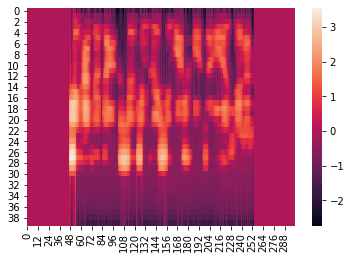

In [18]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/output/2020-12-24-22-42-01/trimAt107-251.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
n=48
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(feature[:,:,0].T)

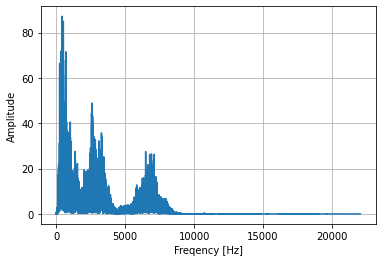

In [290]:
F = np.fft.fft(X) # 変換結果
N = X.shape[0]
freq = np.fft.fftfreq(N, d=1/44100) # 周波数
Amp = np.abs(F/(N/2)) # 振幅
fig, ax = plt.subplots()
ax.plot(freq[1:int(N/2)], Amp[1:int(N/2)])
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.show()

male_sad


<AxesSubplot:>

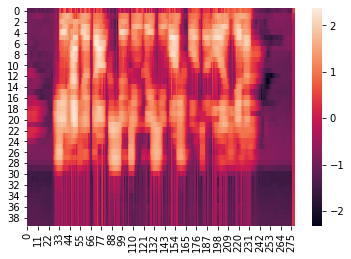

In [19]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/datasets/SAVEE/JK_sa01.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
feature = np.vstack((heatmap_data, (np.zeros((300-heatmap_data.shape[0],40,3),float))))
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(heatmap_data[:,:,0].T)

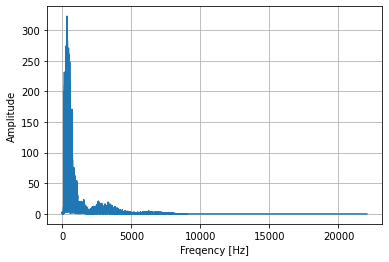

In [219]:
F = np.fft.fft(X) # 変換結果
N = X.shape[0]
freq = np.fft.fftfreq(N, d=1/44100) # 周波数
Amp = np.abs(F/(N/2)) # 振幅
fig, ax = plt.subplots()
ax.plot(freq[1:int(N/2)], Amp[1:int(N/2)])
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.show()

In [190]:
with open("../2020_12_12_SERv3/extractMell.pkl","rb") as file:
    features, label = pickle.load(file)#3,119

male_sad
male_sad


<AxesSubplot:>

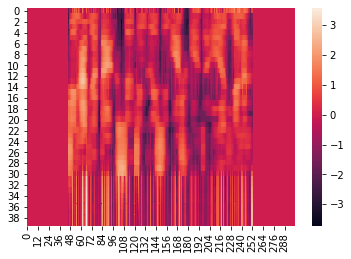

In [351]:
features[0].shape
print(inverselabel(label[0]))
preds = loaded_model.predict_step(np.expand_dims(features[0],axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(features[0][:,:,0].T)

### データの切り落とし

[-0.87553704 -0.82022759 -0.81870805 ... -0.90338043 -0.90353929
 -0.89245354]
-3.636901206734162e-16


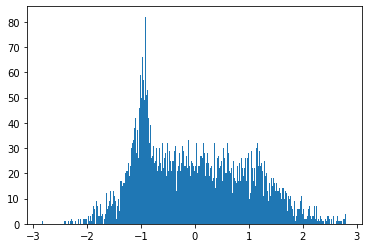

In [178]:
print(heatmap_data[:,:,0].flatten())
print(heatmap_data[:,:,0].mean())
mins = heatmap_data[:,:,0].min()
maxs = heatmap_data[:,:,0].max()
plt.hist(heatmap_data[:,:,0].flatten(), bins=int((maxs-mins)*100 + 1)) #階級の幅を1としてヒストグラムを出す。
# 図表の表示
plt.show()

(207, 40)
male_fear


<AxesSubplot:>

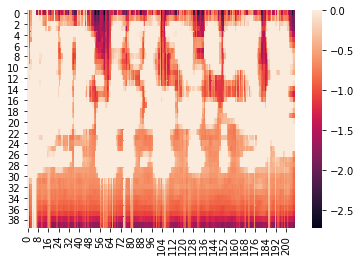

In [349]:
#大きすぎるデータを切りそろえて、見えにくい模様を見やすくする。
#->結果 : かなり切りそろえても感情認識結果に影響なし。やはりCNNは強固。
print(heatmap_data[:,:,0].shape)
edited = heatmap_data
for i in range(edited.shape[0]):
    for j in range(edited.shape[1]):
        if edited[i,j,0] >0:
            edited[i,j,0]=0
        if edited[i,j,1] >1:
            edited[i,j,1]=1
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(edited[:,:,0].T)

### スジが入っていないデータセットをイヤホンを通して感情認識して、結果が狂わなければ、スジがデータセットに悪影響を及ぼしていると考えられる？

(300, 40, 3)
male_sad


<AxesSubplot:>

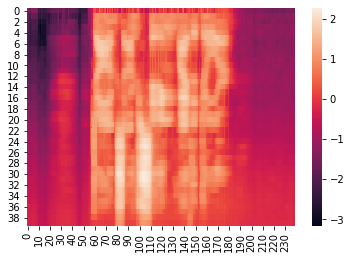

In [37]:
X, samplerate, samplewidth, nchannels = loadwav("/Users/naokitakatani/Documents/datasets/RAVDESS/Actor_07/03-01-04-01-02-02-07.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
feature = np.vstack(((np.zeros((300-heatmap_data.shape[0],40,3),float)),heatmap_data))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(heatmap_data[:,:,0].T)

(300, 40, 3)
male_angry


<AxesSubplot:>

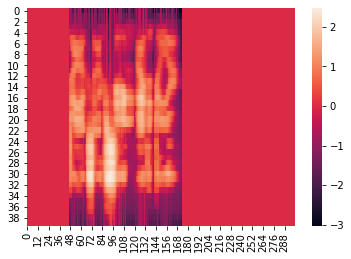

In [36]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/output/2020-12-25-23-49-06/trimAt134-222.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
n=48
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(feature[:,:,0].T)

(300, 40, 3)
female_disgust


<AxesSubplot:>

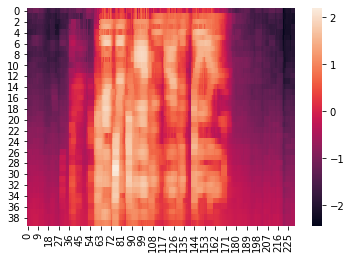

In [35]:
X, samplerate, samplewidth, nchannels = loadwav("/Users/naokitakatani/Documents/datasets/RAVDESS/Actor_22/03-01-05-01-01-02-22.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
feature = np.vstack((heatmap_data,(np.zeros((300-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(heatmap_data[:,:,0].T)

(300, 40, 3)
male_angry


<AxesSubplot:>

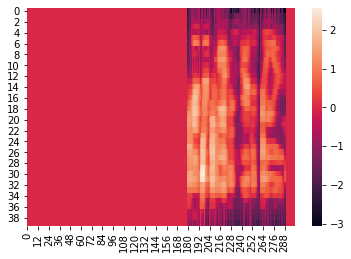

In [55]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/output/2020-12-25-23-59-15/trimAt185-263.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
heatmap_data = mellCepstrum(X, samplerate)
n=180
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(feature[:,:,0].T)

In [57]:
# 音声が300フレームのどの位置にあるかで、感情の結果が大きく変わる。まずはこれを解決しないと、イヤホンマイクを通した時に感情認識結果にどのような影響が出るかを検討できない。

### 新しい学習モデルで検証する。

(300, 40, 3)
male_happy


<AxesSubplot:>

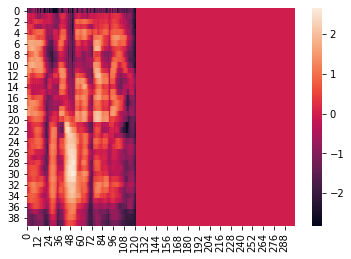

In [61]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/datasets/RAVDESS/Actor_01/03-01-03-02-02-02-01.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
Xt = trimVoice(X)
heatmap_data = mellCepstrum(Xt[0], samplerate)
n=0
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(feature[:,:,0].T)

(300, 40, 3)
female_angry


<AxesSubplot:>

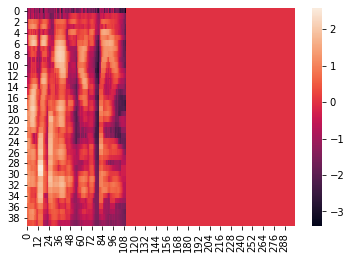

In [44]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/datasets/RAVDESS/Actor_22/03-01-05-01-01-02-22.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
Xt = trimVoice(X)
heatmap_data = mellCepstrum(Xt[0], samplerate)
n=0
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(feature[:,:,0].T)

(300, 40, 3)
male_sad


<AxesSubplot:>

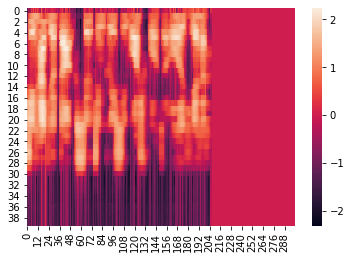

In [83]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/datasets/SAVEE/JK_sa01.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
Xt = trimVoice(X)
heatmap_data = mellCepstrum(Xt[0], samplerate)
n=0
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
sns.heatmap(feature[:,:,0].T)

In [45]:
#MFCC300フレームのどの部分にデータがあっても同じ感情を認識してくれるようになった！

(300, 40, 3)
male_angry
actual label : male_happy


<AxesSubplot:>

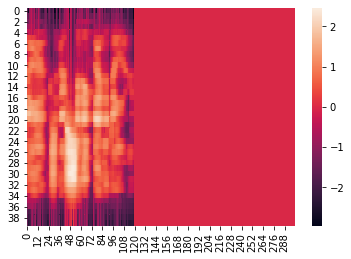

In [62]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/output/2020-12-27-01-36-16/trimAt105-193.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
Xt = trimVoice(X)
heatmap_data = mellCepstrum(Xt[0], samplerate)
n=0
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
print("actual label : male_happy")
sns.heatmap(feature[:,:,0].T)

(300, 40, 3)
female_angry
actual label : female_angry


<AxesSubplot:>

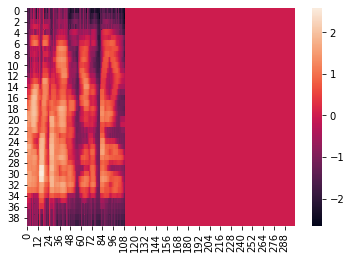

In [71]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/output/2020-12-27-01-40-24/trimAt1526-1603.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
Xt = trimVoice(X)
heatmap_data = mellCepstrum(Xt[0], samplerate)
n=0
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
print("actual label : female_angry")
sns.heatmap(feature[:,:,0].T)

(300, 40, 3)
male_disgust
actual label : male_sad


<AxesSubplot:>

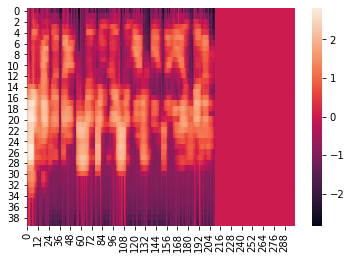

In [177]:
X, samplerate,samplewidth,nchannel = loadwav("/Users/naokitakatani/Documents/2020_12_22_realtime_SERv3/output/2020-12-27-01-44-33/trimAt84-231.wav")
ipd.display(ipd.Audio(X, rate=samplerate))
Xt = trimVoice(X)
heatmap_data = mellCepstrum(Xt[0], samplerate)
n=0
feature = np.vstack(((np.zeros((n,40,3),float)),heatmap_data))
feature = np.vstack((feature, (np.zeros((300-n-heatmap_data.shape[0],40,3),float))))
print(feature.shape)
preds = loaded_model.predict_step(np.expand_dims(feature,axis=0))
preds = preds.numpy()
print("{}".format(inverselabel(preds.argmax())))
print("actual label : male_sad")
sns.heatmap(feature[:,:,0].T)